+-------------------+--------+
|          timestamp|   close|
+-------------------+--------+
|2019-09-02 03:00:00|10391.63|
|2019-09-09 03:00:00|10302.22|
|2019-09-16 03:00:00|10023.04|
|2019-09-23 03:00:00| 8041.96|
|2019-09-30 03:00:00| 7852.79|
|2019-10-07 03:00:00| 8274.66|
|2019-10-14 03:00:00| 8218.23|
|2019-10-21 03:00:00| 9533.32|
|2019-10-28 02:00:00| 9197.88|
|2019-11-04 02:00:00| 9041.31|
|2019-11-11 02:00:00| 8504.04|
|2019-11-18 02:00:00| 6900.86|
|2019-11-25 02:00:00| 7387.38|
|2019-12-02 02:00:00|  7508.2|
|2019-12-09 02:00:00|  7115.0|
|2019-12-16 02:00:00| 7502.92|
|2019-12-23 02:00:00| 7383.67|
|2019-12-30 02:00:00| 7354.36|
|2020-01-06 02:00:00|  8186.7|
|2020-01-13 02:00:00| 8705.85|
+-------------------+--------+
only showing top 20 rows



/home/max/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


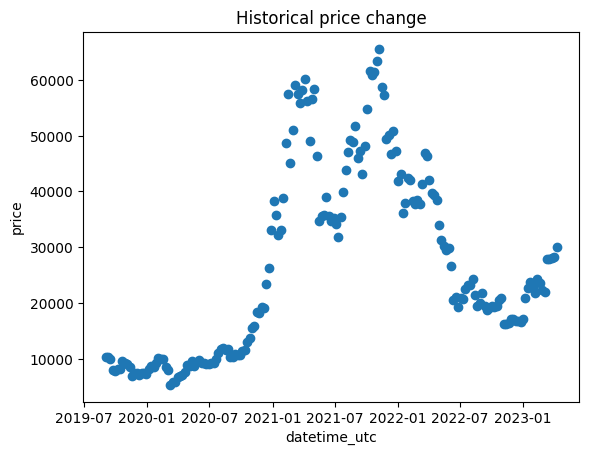

In [15]:
from os import getenv
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_utc_timestamp, udf
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import datetime
import binance
import pandas


ApiKey = getenv("BINANCE_API_KEY")
ApiSecret = getenv("BINANCE_API_SECRET")

BinanceClient = binance.Client(ApiKey, ApiSecret)

# Define the symbol and the interval for the historical data
symbol = "BTCUSDT"
interval = BinanceClient.KLINE_INTERVAL_1WEEK 

# Get the historical data from Binance
klines = BinanceClient.futures_klines(symbol=symbol, interval=interval)

# Convert the klines to a list of tuples, where each tuple contains the timestamp and the close price
data = [(int(kline[0]), float(kline[4])) for kline in klines]

# Create a Spark session and a Spark context
spark = SparkSession.builder.appName("BinanceHistoricalData").getOrCreate()
sc = spark.sparkContext

# Create an RDD from the data
rdd = sc.parallelize(data)

# Convert the RDD to a DataFrame
df = spark.createDataFrame(rdd, ["timestamp", "close"])

# Convert bigint to datetime object (assuming timestamp is in milliseconds)
from_bigint_timestamp_udf = udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000.0), TimestampType())

# Convert timestamp column to UTC datetime format
df = df.withColumn("timestamp", from_bigint_timestamp_udf(col("timestamp")))

df.show()

pandas_df = df.select(col("timestamp"), col("close")).toPandas()

# Convert timestamp column to datetime datatype and fix FutureWarning
pandas_df["timestamp"] = pandas.to_datetime(pandas_df["timestamp"], format='%Y-%m-%d %H:%M:%S').astype("datetime64[ns]", copy=False)

# Build the scatter plot
plt.scatter(pandas_df["timestamp"], pandas_df["close"])
plt.xlabel("datetime_utc")
plt.ylabel("price")
plt.title("Historical price change")
plt.show()